In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
from fastai.imports import *

In [3]:
import glob
import cv2
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.autograd as autograd
import torch.optim as optim
from torch.autograd import Variable
import matplotlib.pyplot as plt
import random
from tqdm import tqdm_notebook as tqdm
import multiprocessing
import os.path
import csv
import copy
import joblib
import pandas as pd
from torchvision import datasets
import torchvision
from torchviz import make_dot
import seaborn as sns; sns.set(color_codes=True)
sns.set_style("white")

In [4]:
USE_CUDA = True

def w(v):
    if USE_CUDA:
        return v.cuda()
    return v


In [5]:
!mkdir -p _cache
cache = joblib.Memory(cachedir='_cache', verbose=0)

# Intro

This notebook is a reproduction of the paper "Learning to Learn by Gradient Descent by Gradient Descent" (https://arxiv.org/abs/1606.04474). 

In a word, this paper is trying to replace the optimizers normally used for neural networks (eg Adam, RMSprop, SGD etc.) by a recurrent neural network: after all, gradient descent is fundamentally a **sequence** of updates (from the output layer of the neural net back to the input), in between which a **state** must be stored. Thus we can think of an optimizer as a mini-RNN. The idea in this paper is to actually train that RNN instead of using a generic algorithm like Adam/SGD/etc..

## Loss

Reminder of the loss function:
$$\mathcal{L}(\phi) = \mathbb{E}_f \left[ \sum_{t=1}^T w_t f(\theta_2) \right]$$
where
$$\theta_{t+1} = \theta_t + g_t$$
$$\begin{bmatrix} g_t \\ h_{t+1} \end{bmatrix} = m(\nabla_t, h_t, \phi)$$

The $w_t$ are arbitrary weights for each timestep. If we only set the last $w_t$ to 1 and the rest to 0, we are optimizing for the best **final** result with our optimizee. This seems reasonable, but it makes it much harder to train. Instead we will use $w_t$ = 1 for all $t$. $\nabla_t = \nabla_{\theta} f(\theta_t)$.

$f$ is the *optimizee* function, and $\theta_t$ is its parameters at time $t$.
$m$ is the *optimizer* function, $\phi$ is its parameters. $h_t$ is its state at time $t$. $g_t$ is the update it outputs at time $t$.

The plan is thus to use gradient descent on $\phi$ in order to minimize $\mathcal{L}(\phi)$, which should give us an optimizer that is capable of optimizing $f$ efficiently.

As the paper mention, it is important that the gradients in dashed lines in the figure below are **not** propagated during gradient descent.

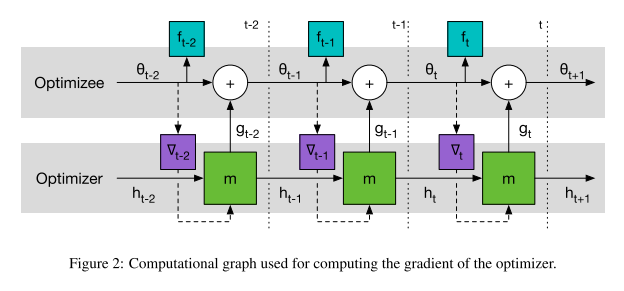

Basically this is nothing we wouldn't expect: the loss of the optimizer neural net is simply the average training loss of the optimizee as it is trained by the optimizer. The optimizer takes in the gradient of the current coordinate of the optimizee as well as its previous state, and outputs a suggested update that we hope will reduce the optimizee's loss as fast as possible.

## Coordinatewise

This section is phrased in a way that is a bit confusing to me, but I think it is actually quite simple: what it means is simply this: every single "*coordinate*" has its own state (though the optimizer itself is shared), and information is not shared across coordinates.

The thing I am not 100% sure about is what a "coordinate" is supposed to be. My guess, however, is that it is simply a weight or a bias. In other words, if we have a network with 100 weights and biases, there will be 100 hidden states involved in optimizing it, which means that effectively there will be 100 instances of our optimizer network running in parallel as we optimize.

# Experiment repro

## Quadratic functions

These are pretty simple: our optimizer is supposed to find a 10-element vector called $\theta$ that, when multiplied by a 10x10 matrix called $W$, is as close as possible to a 10-element vector called $y$. Both $y$ and $W$ are generated randomly. The error is simply the squared error.

In [6]:
class QuadraticLoss:
    def __init__(self, **kwargs):
        self.W = w(Variable(torch.randn(10, 10)))
        self.y = w(Variable(torch.randn(10)))
        
    def get_loss(self, theta):
        return torch.sum((self.W.matmul(theta) - self.y)**2)
    
class QuadOptimizee(nn.Module):
    def __init__(self, theta=None):
        super().__init__()
        # Note: assuming the same optimization for theta as for
        # the function to find out itself.
        if theta is None:
            self.theta = nn.Parameter(torch.zeros(10))
        else:
            self.theta = theta
        
    def forward(self, target):
        return target.get_loss(self.theta)
    
    def all_named_parameters(self):
        return [('theta', self.theta)]
        
class Optimizer(nn.Module):
    def __init__(self, preproc=False, hidden_sz=20, preproc_factor=10.0):
        super().__init__()
        self.hidden_sz = hidden_sz
        if preproc:
            self.recurs = nn.LSTMCell(2, hidden_sz)
        else:
            self.recurs = nn.LSTMCell(1, hidden_sz)
        self.recurs2 = nn.LSTMCell(hidden_sz, hidden_sz)
        self.output = nn.Linear(hidden_sz, 1)
        self.preproc = preproc
        self.preproc_factor = preproc_factor
        self.preproc_threshold = np.exp(-preproc_factor)
        
    def forward(self, inp, hidden, cell):
        if self.preproc:
            # Implement preproc described in Appendix A
            
            # Note: we do all this work on tensors, which means
            # the gradients won't propagate through inp. This
            # should be ok because the algorithm involves
            # making sure that inp is already detached.
            inp = inp.data
            inp2 = w(torch.zeros(inp.size()[0], 2))
            keep_grads = torch.abs(inp) >= self.preproc_threshold
            inp2[:, 0][keep_grads] = torch.log(torch.abs(inp[keep_grads]) + 1e-8) / self.preproc_factor
            inp2[:, 1][keep_grads] = torch.sign(inp[keep_grads])
            
            inp2[:, 0][~keep_grads] = -1
            inp2[:, 1][~keep_grads] = float(np.exp(self.preproc_factor)) * inp[~keep_grads]
            inp = w(Variable(inp2))
        hidden0, cell0 = self.recurs(inp, (hidden[0], cell[0]))
        hidden1, cell1 = self.recurs2(hidden0, (hidden[1], cell[1]))
        return self.output(hidden1), (hidden0, hidden1), (cell0, cell1)
    

> Each function was optimized for 100 steps and the trained optimizers were unrolled for 20 steps.

I assume this means that each epoch is made up of trying to optimize a
new random function for 100 steps, but we are doing an update of the
optimizer every 20 steps. The number of epochs is thus unspecified, but
according to the graphs it seems to be 100 too.

In [7]:
def detach_var(v):
    var = w(Variable(v.data, requires_grad=True))
    var.retain_grad()
    return var

def do_fit(opt_net, meta_opt, target_cls, target_to_opt, unroll, optim_it, n_epochs, out_mul, should_train=True):
    if should_train:
        opt_net.train()
    else:
        opt_net.eval()
        unroll = 1
    
    target = target_cls(training=should_train)
    optimizee = w(target_to_opt())
    n_params = 0
    for p in optimizee.parameters():
        n_params += int(np.prod(p.size()))
    hidden_states = [w(Variable(torch.zeros(n_params, opt_net.hidden_sz))) for _ in range(2)]
    cell_states = [w(Variable(torch.zeros(n_params, opt_net.hidden_sz))) for _ in range(2)]
    all_losses_ever = []
    if should_train:
        meta_opt.zero_grad()
    all_losses = None
    for iteration in range(1, optim_it + 1):
        loss = optimizee(target)
                    
        if all_losses is None:
            all_losses = loss
        else:
            all_losses += loss
        
        all_losses_ever.append(loss.data.cpu().numpy()[0])
        loss.backward(retain_graph=should_train)

        offset = 0
        result_params = {}
        hidden_states2 = [w(Variable(torch.zeros(n_params, opt_net.hidden_sz))) for _ in range(2)]
        cell_states2 = [w(Variable(torch.zeros(n_params, opt_net.hidden_sz))) for _ in range(2)]
        for name, p in optimizee.all_named_parameters():
            cur_sz = int(np.prod(p.size()))
            # We do this so the gradients are disconnected from the graph but we still get
            # gradients from the rest
            gradients = detach_var(p.grad.view(cur_sz, 1))
            updates, new_hidden, new_cell = opt_net(
                gradients,
                [h[offset:offset+cur_sz] for h in hidden_states],
                [c[offset:offset+cur_sz] for c in cell_states]
            )
            for i in range(len(new_hidden)):
                hidden_states2[i][offset:offset+cur_sz] = new_hidden[i]
                cell_states2[i][offset:offset+cur_sz] = new_cell[i]
            result_params[name] = p + updates.view(*p.size()) * out_mul
            result_params[name].retain_grad()
            
        if iteration % unroll == 0:
            if should_train:
                meta_opt.zero_grad()
                all_losses.backward()
                meta_opt.step()
                
            all_losses = None
                        
            optimizee = w(target_to_opt(**{k: detach_var(v) for k, v in result_params.items()}))
            hidden_states = [detach_var(v) for v in hidden_states2]
            cell_states = [detach_var(v) for v in cell_states2]
            
        else:
            optimizee = w(target_to_opt(**result_params))
            assert len(list(optimizee.all_named_parameters()))
            hidden_states = hidden_states2
            cell_states = cell_states2
            
    return all_losses_ever


@cache.cache
def fit_optimizer(target_cls, target_to_opt, preproc=False, unroll=20, optim_it=100, n_epochs=20, n_tests=100, lr=0.001, out_mul=1.0):
    opt_net = w(Optimizer(preproc=preproc))
    meta_opt = optim.Adam(opt_net.parameters(), lr=lr)
    
    best_net = None
    best_loss = 100000000000000000
    
    for _ in tqdm(range(n_epochs), 'epochs'):
        for _ in tqdm(range(20), 'iterations'):
            do_fit(opt_net, meta_opt, target_cls, target_to_opt, unroll, optim_it, n_epochs, out_mul, should_train=True)
        
        loss = (np.mean([
            np.sum(do_fit(opt_net, meta_opt, target_cls, target_to_opt, unroll, optim_it, n_epochs, out_mul, should_train=False))
            for _ in tqdm(range(n_tests), 'tests')
        ]))
        print(loss)
        if loss < best_loss:
            print(best_loss, loss)
            best_loss = loss
            best_net = copy.deepcopy(opt_net.state_dict())
            
    return best_loss, best_net
  
    


In [8]:
for lr in tqdm([1.0, 0.3, 0.1, 0.03, 0.01, 0.003, 0.001, 0.0003, 0.0001, 0.00003, 0.00001], 'all'):
    print('Trying lr:', lr)
    print(fit_optimizer(QuadraticLoss, QuadOptimizee, lr=lr)[0])
    
loss, quad_optimizer = fit_optimizer(QuadraticLoss, QuadOptimizee, lr=0.003, n_epochs=100)
print(loss)

Widget Javascript not detected.  It may not be installed or enabled properly.


Trying lr: 1.0
147004.0
Trying lr: 0.3
172.019
Trying lr: 0.1
77.2074
Trying lr: 0.03
66.8087
Trying lr: 0.01
60.0625
Trying lr: 0.003
70.9825
Trying lr: 0.001
91.5729
Trying lr: 0.0003
151.605
Trying lr: 0.0001
181.629
Trying lr: 3e-05
234.214
Trying lr: 1e-05
349.012

55.7698


In [9]:
@cache.cache
def fit_normal(target_cls, target_to_opt, opt_class, n_tests=100, n_epochs=100, **kwargs):
    results = []
    for i in tqdm(range(n_tests), 'tests'):
        target = target_cls(training=False)
        optimizee = w(target_to_opt())
        optimizer = opt_class(optimizee.parameters(), **kwargs)
        total_loss = []
        for _ in range(n_epochs):
            loss = optimizee(target)
            
            total_loss.append(loss.data.cpu().numpy()[0])
            
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
        results.append(total_loss)
    return results

def find_best_lr_normal(target_cls, target_to_opt, opt_class, **extra_kwargs):
    best_loss = 1000000000000000.0
    best_lr = 0.0
    for lr in tqdm([1.0, 0.3, 0.1, 0.03, 0.01, 0.003, 0.001, 0.0003, 0.0001, 0.00003, 0.00001], 'Learning rates'):
        try:
            loss = best_loss + 1.0
            loss = np.mean([np.sum(s) for s in fit_normal(target_cls, target_to_opt, opt_class, lr=lr, **extra_kwargs)])
        except RuntimeError:
            pass
        if loss < best_loss:
            best_loss = loss
            best_lr = lr
    return best_loss, best_lr

In [10]:
NORMAL_OPTS = [(optim.Adam, {}), (optim.RMSprop, {}), (optim.SGD, {}), (optim.SGD, {'nesterov': True, 'momentum': 0.9})]
OPT_NAMES = ['ADAM', 'RMSprop', 'SGD', 'NAG']

# NB: the momentum parameter for nesterov was found from the following file: https://github.com/torch/optim/blob/master/nag.lua
# since it is mentioned in the paper that "When an optimizer has more parameters than just a learning rate (e.g. decay coefficients for ADAM) we use the default values from the optim package in Torch7."
for opt, kwargs in NORMAL_OPTS:
    print(find_best_lr_normal(QuadraticLoss, QuadOptimizee, opt, **kwargs))

Widget Javascript not detected.  It may not be installed or enabled properly.



(103.30794, 0.1)


Widget Javascript not detected.  It may not be installed or enabled properly.



(116.20286, 0.03)


Widget Javascript not detected.  It may not be installed or enabled properly.


Widget Javascript not detected.  It may not be installed or enabled properly.


Widget Javascript not detected.  It may not be installed or enabled properly.


Widget Javascript not detected.  It may not be installed or enabled properly.


Widget Javascript not detected.  It may not be installed or enabled properly.



(186.20087, 0.01)


Widget Javascript not detected.  It may not be installed or enabled properly.


Widget Javascript not detected.  It may not be installed or enabled properly.


Widget Javascript not detected.  It may not be installed or enabled properly.


Widget Javascript not detected.  It may not be installed or enabled properly.


Widget Javascript not detected.  It may not be installed or enabled properly.



(90.841278, 0.01)


In [11]:
QUAD_LRS = [0.1, 0.03, 0.01, 0.01]
fit_data = np.zeros((100, 100, len(OPT_NAMES) + 1))
for i, ((opt, extra_kwargs), lr) in enumerate(zip(NORMAL_OPTS, QUAD_LRS)):
    np.random.seed(0)
    fit_data[:, :, i] = np.array(fit_normal(QuadraticLoss, QuadOptimizee, opt, lr=lr, **extra_kwargs))

opt = w(Optimizer())
opt.load_state_dict(quad_optimizer)
np.random.seed(0)
fit_data[:, :, len(OPT_NAMES)] = np.array([do_fit(opt, None, QuadraticLoss, QuadOptimizee, 1, 100, 100, out_mul=1.0, should_train=False) for _ in range(100)])

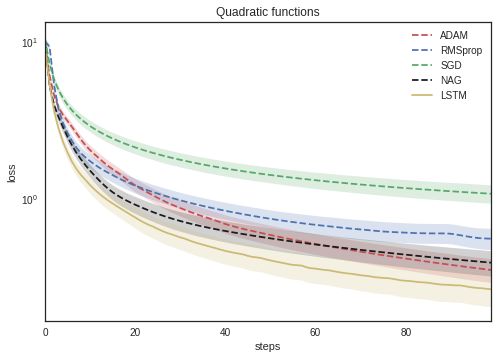

In [12]:
ax = sns.tsplot(data=fit_data[:, :, :], condition=OPT_NAMES + ['LSTM'], linestyle='--', color=['r', 'b', 'g', 'k', 'y'])
ax.lines[-1].set_linestyle('-')
ax.legend()
plt.yscale('log')
plt.xlabel('steps')
plt.ylabel('loss')
plt.title('Quadratic functions')
plt.show()

## MNIST

In [13]:
class MNISTLoss:
    def __init__(self, training=True):
        dataset = datasets.MNIST(
            './mnist', train=True, download=True,
            transform=torchvision.transforms.ToTensor()
        )
        indices = list(range(len(dataset)))
        np.random.RandomState(10).shuffle(indices)
        if training:
            indices = indices[:len(indices) // 2]
        else:
            indices = indices[len(indices) // 2:]

        self.loader = torch.utils.data.DataLoader(
            dataset, batch_size=128,
            sampler=torch.utils.data.sampler.SubsetRandomSampler(indices))
        
        self.batches = []
        self.cur_batch = 0
        
    def sample(self):
        if self.cur_batch >= len(self.batches):
            self.batches = []
            self.cur_batch = 0
            for b in self.loader:
                self.batches.append(b)
        batch = self.batches[self.cur_batch]
        self.cur_batch += 1
        return batch

class MNISTNet(nn.Module):
    def __init__(self, layer_size=20, n_layers=1, **kwargs):
        super().__init__()
        # Sadly this network needs to be implemented without using the convenient pytorch
        # abstractions such as nn.Linear, because afaik there is no way to load parameters
        # in those in a way that preserves gradients.
        if kwargs != {}:
            self.params = kwargs
        else:
            inp_size = 28*28
            self.params = {}
            for i in range(n_layers):
                self.params[f'mat_{i}'] = nn.Parameter(torch.randn(inp_size, layer_size) * 0.001) # TODO: use a better initialization
                self.params[f'bias_{i}'] = nn.Parameter(torch.zeros(layer_size))
                inp_size = layer_size

            self.params['final_mat'] = nn.Parameter(torch.randn(inp_size, 10) * 0.001) # TODO:init
            self.params['final_bias'] = nn.Parameter(torch.zeros(10))
            
            # Put it all in a module list so that ordinary optimizers can find them.
            self.mods = nn.ParameterList()
            for v in self.params.values():
                self.mods.append(v)
                
        self.activation = nn.Sigmoid()
        self.loss = nn.NLLLoss()
                
    def all_named_parameters(self):
        return [(k, v) for k, v in self.params.items()]
    
    def forward(self, loss):
        inp, out = loss.sample()
        inp = w(Variable(inp.view(inp.size()[0], 28*28)))
        out = w(Variable(out))
        
        cur_layer = 0
        while f'mat_{cur_layer}' in self.params:
            inp = self.activation(torch.matmul(inp, self.params[f'mat_{cur_layer}']) + self.params[f'bias_{cur_layer}'])
            cur_layer += 1
                    
        inp = F.log_softmax(torch.matmul(inp, self.params['final_mat']) + self.params['final_bias'])
        l = self.loss(inp, out)
        return l

In [14]:
for lr in tqdm(sorted([1.0, 0.3, 0.1, 0.03, 0.01, 0.003, 0.001, 0.0003, 0.0001, 0.00003, 0.00001], key=lambda x: np.abs(x - 0.003)), 'all'):
    print('Trying lr:', lr)
    print(fit_optimizer(MNISTLoss, MNISTNet, lr=lr, out_mul=0.1, preproc=True, n_tests=5, n_epochs=10)[0])
    
    
loss, mnist_optimizer = fit_optimizer(MNISTLoss, MNISTNet, lr=0.01, n_epochs=50, n_tests=20, out_mul=0.1, preproc=True)
print(loss)

Widget Javascript not detected.  It may not be installed or enabled properly.


Trying lr: 0.003
69.3574
Trying lr: 0.001
83.3093
Trying lr: 0.0003
123.949
Trying lr: 0.0001
149.056
Trying lr: 3e-05
135.877
Trying lr: 1e-05
230.355
Trying lr: 0.01
64.6128
Trying lr: 0.03
66.0366
Trying lr: 0.1
230.175
Trying lr: 0.3
230.249
Trying lr: 1.0
230.258

46.9771


In [15]:
for opt, kwargs in NORMAL_OPTS:
    print(find_best_lr_normal(MNISTLoss, MNISTNet, opt, **kwargs, n_tests=10))
    

Widget Javascript not detected.  It may not be installed or enabled properly.



(77.478592, 0.03)


Widget Javascript not detected.  It may not be installed or enabled properly.



(94.097038, 0.01)


Widget Javascript not detected.  It may not be installed or enabled properly.



(152.67354, 1.0)


Widget Javascript not detected.  It may not be installed or enabled properly.



(80.239899, 1.0)


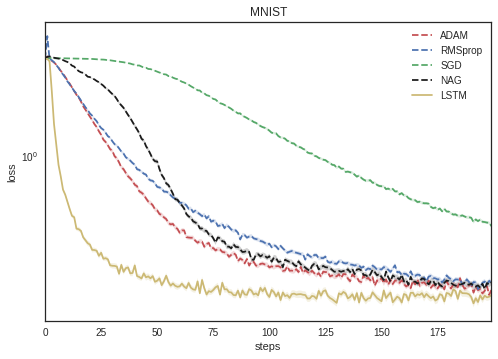

In [16]:
QUAD_LRS = [0.03, 0.01, 1.0, 1.0]
N_TESTS = 100

fit_data = np.zeros((N_TESTS, 200, len(OPT_NAMES) + 1))
for i, ((opt, extra_kwargs), lr) in enumerate(zip(NORMAL_OPTS, QUAD_LRS)):
    np.random.seed(0)
    fit_data[:, :, i] = np.array(fit_normal(MNISTLoss, MNISTNet, opt, lr=lr, n_tests=N_TESTS, n_epochs=200, **extra_kwargs))

@cache.cache
def get_fit_dict_test(n_tests, opt_dict, *args, **kwargs):
    opt = w(Optimizer(preproc=True))
    opt.load_state_dict(opt_dict)
    np.random.seed(0)
    return [do_fit(opt, *args, **kwargs) for _ in tqdm(range(N_TESTS), 'optimizer')]

fit_data[:, :, len(OPT_NAMES)] = np.array(get_fit_dict_test(N_TESTS, mnist_optimizer, None, MNISTLoss, MNISTNet, 1, 200, 200, out_mul=0.1, should_train=False))

ax = sns.tsplot(data=fit_data[:, :, :], condition=OPT_NAMES + ['LSTM'], linestyle='--', color=['r', 'b', 'g', 'k', 'y'])
ax.lines[-1].set_linestyle('-')
ax.legend()
plt.yscale('log')
plt.xlabel('steps')
plt.ylabel('loss')
plt.title('MNIST')
plt.show()

In [17]:
class MNISTNet2Layer(MNISTNet):
    def __init__(self, *args, **kwargs):
        super().__init__(n_layers=2, *args, **kwargs)
        
class MNISTNetBig(MNISTNet):
    def __init__(self, *args, **kwargs):
        super().__init__(layer_size=40, *args, **kwargs)
        
class MNISTRelu(MNISTNet):
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.activation = nn.ReLU()

In [18]:
for opt, kwargs in NORMAL_OPTS:
    print(find_best_lr_normal(MNISTLoss, MNISTNet2Layer, opt, **kwargs, n_tests=10))

for opt, kwargs in NORMAL_OPTS:
    print(find_best_lr_normal(MNISTLoss, MNISTNetBig, opt, **kwargs, n_tests=10))

for opt, kwargs in NORMAL_OPTS:
    print(find_best_lr_normal(MNISTLoss, MNISTRelu, opt, **kwargs, n_tests=10))


Widget Javascript not detected.  It may not be installed or enabled properly.



(206.7471, 0.01)


Widget Javascript not detected.  It may not be installed or enabled properly.



(204.67285, 0.003)


Widget Javascript not detected.  It may not be installed or enabled properly.



(230.1969, 0.03)


Widget Javascript not detected.  It may not be installed or enabled properly.



(202.48624, 1.0)


Widget Javascript not detected.  It may not be installed or enabled properly.



(99.786255, 0.03)


Widget Javascript not detected.  It may not be installed or enabled properly.



(90.57737, 0.01)


Widget Javascript not detected.  It may not be installed or enabled properly.



(185.34653, 1.0)


Widget Javascript not detected.  It may not be installed or enabled properly.



(124.91872, 1.0)


Widget Javascript not detected.  It may not be installed or enabled properly.



(57.986462, 0.03)


Widget Javascript not detected.  It may not be installed or enabled properly.



(65.22245, 0.003)


Widget Javascript not detected.  It may not be installed or enabled properly.



(160.08694, 0.3)


Widget Javascript not detected.  It may not be installed or enabled properly.



(89.470779, 0.3)


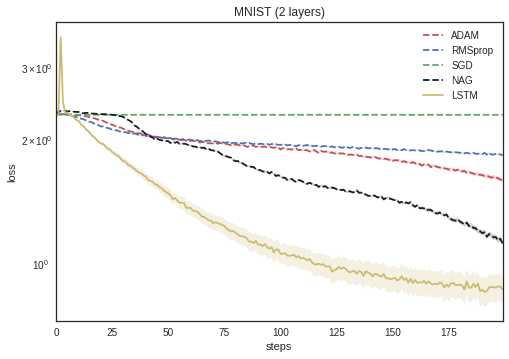

In [19]:
QUAD_LRS = [0.01, 0.003, 0.03, 1.0]
N_TESTS = 100

fit_data = np.zeros((N_TESTS, 200, len(OPT_NAMES) + 1))
for i, ((opt, extra_kwargs), lr) in enumerate(zip(NORMAL_OPTS, QUAD_LRS)):
    np.random.seed(0)
    fit_data[:, :, i] = np.array(fit_normal(MNISTLoss, MNISTNet2Layer, opt, lr=lr, n_tests=N_TESTS, n_epochs=200, **extra_kwargs))

fit_data[:, :, len(OPT_NAMES)] = np.array(get_fit_dict_test(N_TESTS, mnist_optimizer, None, MNISTLoss, MNISTNet2Layer, 1, 200, 200, out_mul=0.1, should_train=False))

ax = sns.tsplot(data=fit_data[:, :, :], condition=OPT_NAMES + ['LSTM'], linestyle='--', color=['r', 'b', 'g', 'k', 'y'])
ax.lines[-1].set_linestyle('-')
ax.legend()
plt.yscale('log')
plt.xlabel('steps')
plt.ylabel('loss')
plt.title('MNIST (2 layers)')
plt.show()

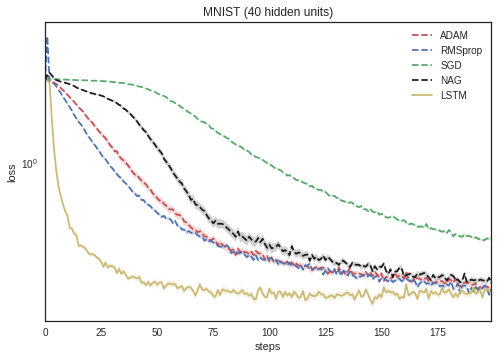

In [20]:
QUAD_LRS = [0.03, 0.01, 1.0, 1.0]
N_TESTS = 100

fit_data = np.zeros((N_TESTS, 200, len(OPT_NAMES) + 1))
for i, ((opt, extra_kwargs), lr) in enumerate(zip(NORMAL_OPTS, QUAD_LRS)):
    np.random.seed(0)
    fit_data[:, :, i] = np.array(fit_normal(MNISTLoss, MNISTNetBig, opt, lr=lr, n_tests=N_TESTS, n_epochs=200, **extra_kwargs))

fit_data[:, :, len(OPT_NAMES)] = np.array(get_fit_dict_test(N_TESTS, mnist_optimizer, None, MNISTLoss, MNISTNetBig, 1, 200, 200, out_mul=0.1, should_train=False))

ax = sns.tsplot(data=fit_data[:, :, :], condition=OPT_NAMES + ['LSTM'], linestyle='--', color=['r', 'b', 'g', 'k', 'y'])
ax.lines[-1].set_linestyle('-')
ax.legend()
plt.yscale('log')
plt.xlabel('steps')
plt.ylabel('loss')
plt.title('MNIST (40 hidden units)')
plt.show()

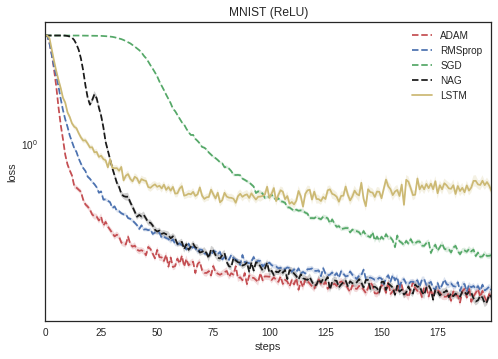

In [21]:
QUAD_LRS = [0.03, 0.003, 0.3, 0.3]
N_TESTS = 100

fit_data = np.zeros((N_TESTS, 200, len(OPT_NAMES) + 1))
for i, ((opt, extra_kwargs), lr) in enumerate(zip(NORMAL_OPTS, QUAD_LRS)):
    np.random.seed(0)
    fit_data[:, :, i] = np.array(fit_normal(MNISTLoss, MNISTRelu, opt, lr=lr, n_tests=N_TESTS, n_epochs=200, **extra_kwargs))

fit_data[:, :, len(OPT_NAMES)] = np.array(get_fit_dict_test(N_TESTS, mnist_optimizer, None, MNISTLoss, MNISTRelu, 1, 200, 200, out_mul=0.1, should_train=False))

ax = sns.tsplot(data=fit_data[:, :, :], condition=OPT_NAMES + ['LSTM'], linestyle='--', color=['r', 'b', 'g', 'k', 'y'])
ax.lines[-1].set_linestyle('-')
ax.legend()
plt.yscale('log')
plt.xlabel('steps')
plt.ylabel('loss')
plt.title('MNIST (ReLU)')
plt.show()